# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Название проекта: анализ месторождений нефти. 

Цели: найти месторождение, удовлетворяющее условиям компании-заказчика.

## Загрузка и подготовка данных

Импорт библиотек

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q

In [2]:
!pip install phik -q

In [3]:
!pip install shap -q

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import make_scorer
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import shap
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

Загрузка данных

In [5]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')
data_0.name = 'data_0'
data_1.name = 'data_1'
data_2.name = 'data_2'

Обозначим константы, которые нам понадобятся в работе

In [6]:
REGION_BUDGET_RUB = 10*10**9 # Бюджет на разработку 200 скважин в регионе
TOTAL_QUANTITY_POINTS = 500 # При разведке региона исследуют 500 точек
SELECTED_QUANTITY_POINTS = 200 # с помощью машинного обучения выбирают 200 точек лучших для разработки
BUDGET_QUANTITY_POINTS_RUB = REGION_BUDGET_RUB / SELECTED_QUANTITY_POINTS
BARREL_INCOME_RUB = 450 # доход с каждого барреля
PRODUCT_UNITS_INCOME_RUB = 450 * 10**3 # доход с каждой единицы продукта
LOSS_PROBABILITY_THRESHOLD_PERSENT = 2,5 # порог вероятности убытков, максимальное допустимое значение, проценты

Предобработка данных

In [7]:
def describe_df(DataFrame):

    print('Название датасета:', DataFrame.name, '\n')

    print('Количество столбцов:', DataFrame.shape[1])
    print('Количество строк:', DataFrame.shape[0], '\n')

    print('Пропуски:\n')
    print(DataFrame.isna().sum(),'\n')
    print('Дубликаты:', DataFrame.duplicated().sum(),'\n')
    print(f'\nТипы данных: \n{DataFrame.dtypes}')

    print('Описание:\n')
    display(DataFrame.describe())
    print()

    print('Dataframe начало\n')
    display(DataFrame.head())
    print()
    print('Dataframe конец\n')
    display(DataFrame.tail())

In [8]:
describe_df(data_0)

Название датасета: data_0 

Количество столбцов: 5
Количество строк: 100000 

Пропуски:

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Дубликаты: 0 


Типы данных: 
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object
Описание:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Dataframe начало



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Dataframe конец



,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


In [9]:
describe_df(data_1)

Название датасета: data_1 

Количество столбцов: 5
Количество строк: 100000 

Пропуски:

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Дубликаты: 0 


Типы данных: 
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object
Описание:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Dataframe начало



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Dataframe конец



,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


In [10]:
describe_df(data_2)

Название датасета: data_2 

Количество столбцов: 5
Количество строк: 100000 

Пропуски:

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Дубликаты: 0 


Типы данных: 
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object
Описание:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



Dataframe начало



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Dataframe конец



,id,f0,f1,f2,product
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


Все датасеты содержат по 100000 строк, по 5 столбцов, пропусков и явных дубликатов не обнаружено. На первый взгляд никаких аномалий не обнаружено. 

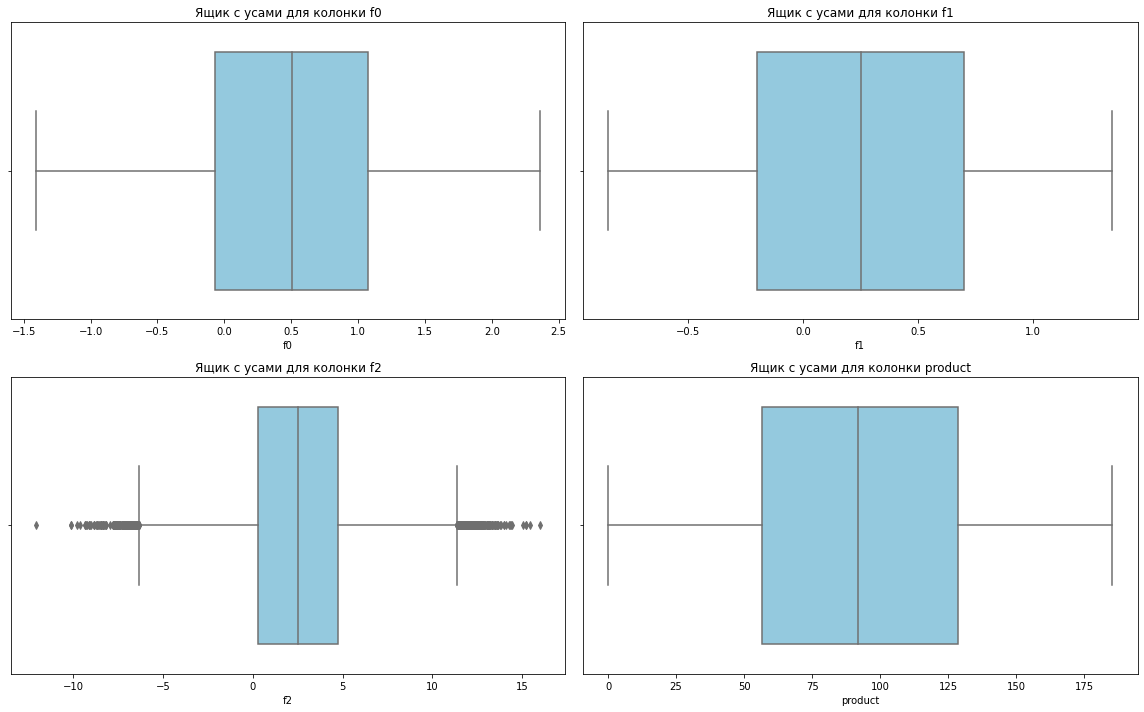

In [11]:
numerical_columns = ['f0', 'f1', 'f2', 'product']

plt.figure(figsize=(16, 10))

for i, column in enumerate(numerical_columns, 1):
    if column in data_0.columns:
        plt.subplot(2, 2, i)
        sns.boxplot(x=data_0[column], color='skyblue')
        plt.title(f'Ящик с усами для колонки {column}')
        plt.xlabel(column)

plt.tight_layout()
plt.show()

Видим, что в столбце f2 наблюдаются выбросы, которые могут мешать модели обучаться. Стоит от них избавиться.

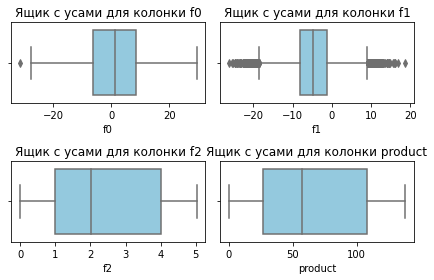

In [12]:
for i, column in enumerate(numerical_columns, 1):
    if column in data_1.columns:
        plt.subplot(2, 2, i)
        sns.boxplot(x=data_1[column], color='skyblue')
        plt.title(f'Ящик с усами для колонки {column}')
        plt.xlabel(column)

plt.tight_layout()
plt.show()

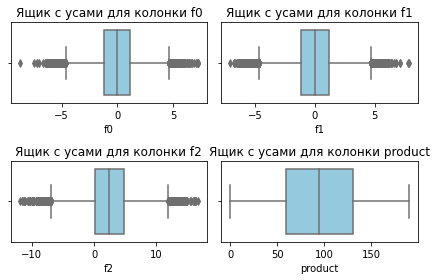

In [13]:
for i, column in enumerate(numerical_columns, 1):
    if column in data_2.columns:
        plt.subplot(2, 2, i)
        sns.boxplot(x=data_2[column], color='skyblue')
        plt.title(f'Ящик с усами для колонки {column}')
        plt.xlabel(column)

plt.tight_layout()
plt.show()

Аналогичные выбросы у колонки f1 датасета под номером 2, у колонок f0, f1, f2 датасета под номером 3.

In [14]:
def remove_ouliers(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    
    q75=np.array(frame[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index

In [15]:
noise_data = [(data_0,"f2"),
 (data_1,"f1"),
 (data_1,"f0"),
 (data_2,"f1"),
 (data_2,"f2")]

for frame,column in noise_data:
    indexes = remove_ouliers(frame,column)
    frame.drop(indexes,axis = 0,inplace = True)

Количество строк, выбранных для удаления:  506
Количество строк, выбранных для удаления:  636
Количество строк, выбранных для удаления:  1
Количество строк, выбранных для удаления:  684
Количество строк, выбранных для удаления:  583


Данные готовы к обучению.

## Обучение и проверка модели

In [16]:
def linear_model(data):
    target = data['product']
    features = data.drop(['product', 'id'], axis=1)
    
    features_train, features_valid, target_train,target_valid = \
    train_test_split(features, target, test_size=0.25, random_state=42)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    
    predicted_valid_mean = predicted_valid.sum()/len(predicted_valid)
    
    return target_valid, predicted_valid, rmse, predicted_valid_mean

In [17]:
target_valid_0, predicted_valid_0, rmse_0, predicted_valid_mean_0 = linear_model(data_0)
target_valid_1, predicted_valid_1, rmse_1, predicted_valid_mean_1 = linear_model(data_1)
target_valid_2, predicted_valid_2, rmse_2, predicted_valid_mean_2 = linear_model(data_2)

In [18]:
print('Регион_0. Средний предсказанный запас сырья:', predicted_valid_mean_0, 'rmse:', rmse_0)
print('Регион_1. Средний предсказанный запас сырья:', predicted_valid_mean_1, 'rmse:', rmse_1)
print('Регион_2. Средний предсказанный запас сырья:', predicted_valid_mean_2, 'rmse:', rmse_2)

Регион_0. Средний предсказанный запас сырья: 92.3505469646708 rmse: 37.815104778634264
Регион_1. Средний предсказанный запас сырья: 68.96189897916467 rmse: 0.8880473538662839
Регион_2. Средний предсказанный запас сырья: 94.78049178361164 rmse: 39.81709402317025


Получили такие значения среднего запаса сырья и RMSE. 
Регионы 0 и 2 являются более объемными по запасам, но ошибка предсказания модели также выше, поэтому необходимо расчитать прибыли и риски.

## Подготовка к расчёту прибыли

In [19]:
REGION_BUDGET_RUB = 10*10**9 # Бюджет на разработку 200 скважин в регионе
TOTAL_QUANTITY_POINTS = 500 # При разведке региона исследуют 500 точек
SELECTED_QUANTITY_POINTS = 200 # с помощью машинного обучения выбирают 200 точек лучших для разработки
BUDGET_QUANTITY_POINTS_RUB = REGION_BUDGET_RUB / SELECTED_QUANTITY_POINTS
BARREL_INCOME_RUB = 450 # доход с каждого барреля
PRODUCT_UNITS_INCOME_RUB = 450 * 10**3 # доход с каждой единицы продукта
LOSS_PROBABILITY_THRESHOLD_PERSENT = 2,5 # порог вероятности убытков, максимальное допустимое значение, проценты

In [20]:
min_volume_materials = REGION_BUDGET_RUB / SELECTED_QUANTITY_POINTS / BARREL_INCOME_RUB
print(f'Достаточный объём сырья для безубыточной \
разработки новой скважины равен {int(min_volume_materials)} барреля \
или {round(min_volume_materials/1000, 3)} единицы продукта (тыс. баррелей)')

Достаточный объём сырья для безубыточной разработки новой скважины равен 111111 барреля или 111.111 единицы продукта (тыс. баррелей)


Расчитаем отклонение от среднего во всех трех регионах.

In [21]:
predicted_valid_mean_0*1000 - min_volume_materials

-18760.564146440316

In [22]:
predicted_valid_mean_1*1000 - min_volume_materials

-42149.212131946435

In [23]:
predicted_valid_mean_2*1000 - min_volume_materials

-16330.619327499473

In [24]:
print('Средняя расчетная прибыль региона_0',\
      SELECTED_QUANTITY_POINTS *\
      predicted_valid_mean_0 *\
     PRODUCT_UNITS_INCOME_RUB\
     - REGION_BUDGET_RUB)
print('Средняя расчетная прибыль региона_1',\
      SELECTED_QUANTITY_POINTS *\
      predicted_valid_mean_1 *\
     PRODUCT_UNITS_INCOME_RUB\
     - REGION_BUDGET_RUB)
print('Средняя расчетная прибыль региона_2',\
      SELECTED_QUANTITY_POINTS *\
      predicted_valid_mean_2 *\
     PRODUCT_UNITS_INCOME_RUB\
     - REGION_BUDGET_RUB)

Средняя расчетная прибыль региона_0 -1688450773.1796284
Средняя расчетная прибыль региона_1 -3793429091.8751793
Средняя расчетная прибыль региона_2 -1469755739.4749527


Средний запас сырья скважин меньше значения достаточного объема сырья в каждом из трех регионов, однако в регионе_1 ситуация наихудшая.

In [25]:
print('Разница между средним значением нефти в 200 скважинах \
с наибольшим предсказанным объемом нефти со значением безубыточности.\n')
print('Нулевой регион:', pd.Series(predicted_valid_0).sort_values(ascending=False).head(200).mean() - min_volume_materials/1000)
print('Первый регион:', pd.Series(predicted_valid_1).sort_values(ascending=False).head(200).mean() - min_volume_materials/1000)
print('Второй регион:', pd.Series(predicted_valid_2).sort_values(ascending=False).head(200).mean() - min_volume_materials/1000)

Разница между средним значением нефти в 200 скважинах с наибольшим предсказанным объемом нефти со значением безубыточности.

Нулевой регион: 40.60377897650548
Первый регион: 27.65092738725488
Второй регион: 33.46691310366134


Заметим, что средние значения объемов нефти в 200 скажинах с наибольшим предсказанным объемом нефти больше, чем точка безубыточности. По этим значениям лидирует нулевой регион

По прибыли, как мы уже догадывались раньше, наиболее благоприятными являются регионы 0 и 2.

По разнице со средним значением объемов нефти в 200 скважинах и точкой безубыточности является регион 0.

## Расчёт прибыли и рисков 

Для начала приведем датасеты к типу Series.

In [27]:
def series_type(target, pred):
    target = target.reset_index(drop=True)
    pred = pd.Series(pred)
    return target, pred

In [28]:
target_valid_0, predicted_valid_0 = series_type(target_valid_0, predicted_valid_0)
target_valid_1, predicted_valid_1 = series_type(target_valid_1, predicted_valid_1)
target_valid_2, predicted_valid_2 = series_type(target_valid_2, predicted_valid_2)

In [29]:
def total_income(target, probabilities, count, PRODUCT_UNITS_INCOME_RUB, REGION_BUDGET_RUB):
    prob_sort = probabilities.sort_values(ascending=False)
    selected = target[prob_sort.index][:count]
    return int(PRODUCT_UNITS_INCOME_RUB * selected.sum() - REGION_BUDGET_RUB)

Для расчета фактической прибыли берем 200 самых объяемных залежей, вычитаем из этого затраты на разработку.

In [30]:
def bootstrap_regions(target, predicted, SELECTED_QUANTITY_POINTS, PRODUCT_UNITS_INCOME_RUB, REGION_BUDGET_RUB):
    state = RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n = TOTAL_QUANTITY_POINTS, replace=True, random_state=state)
        pred_subsumple = predicted[target_subsample.index]

        values.append(total_income(target_subsample, pred_subsumple, SELECTED_QUANTITY_POINTS, PRODUCT_UNITS_INCOME_RUB, REGION_BUDGET_RUB))
    values = pd.Series(values)
    values_mean = int(values.mean())
    lower = int(values.quantile(q=0.025))
    upper = int(values.quantile(q=0.975))
    risk = int(len(values[values < 0]) / len(values) * 100)
    return values_mean, lower, upper, risk

In [31]:
values_mean_0, lower_0, upper_0, risk_0  = bootstrap_regions(target_valid_0, predicted_valid_0, SELECTED_QUANTITY_POINTS, PRODUCT_UNITS_INCOME_RUB, REGION_BUDGET_RUB)
values_mean_1, lower_1, upper_1, risk_1  = bootstrap_regions(target_valid_1, predicted_valid_1, SELECTED_QUANTITY_POINTS, PRODUCT_UNITS_INCOME_RUB, REGION_BUDGET_RUB)
values_mean_2, lower_2, upper_2, risk_2  = bootstrap_regions(target_valid_2, predicted_valid_2, SELECTED_QUANTITY_POINTS, PRODUCT_UNITS_INCOME_RUB, REGION_BUDGET_RUB)

In [32]:
print('Средняя прибыль лучших месторождений региона_0 равна', values_mean_0)
print('Средняя прибыль лучших месторождений региона_1 равна', values_mean_1)
print('Средняя прибыль лучших месторождений региона_2 равна', values_mean_2)

Средняя прибыль лучших месторождений региона_0 равна 419948759
Средняя прибыль лучших месторождений региона_1 равна 514380773
Средняя прибыль лучших месторождений региона_2 равна 363366976


In [33]:
print('95% доверительный интервал для средней прибыли 200 лучших месторождений региона_0', lower_0, upper_0)
print('95% доверительный интервал для средней прибыли 200 лучших месторождений региона_1', lower_1, upper_1)
print('95% доверительный интервал для средней прибыли 200 лучших месторождений региона_2', lower_2, upper_2)

95% доверительный интервал для средней прибыли 200 лучших месторождений региона_0 -153249526 983471595
95% доверительный интервал для средней прибыли 200 лучших месторождений региона_1 97422948 942818200
95% доверительный интервал для средней прибыли 200 лучших месторождений региона_2 -186074080 941442813


In [34]:
print('Риск убытков региона_0 равен', risk_0, '%')
print('Риск убытков региона_1 равен', risk_1, '%')
print('Риск убытков региона_2 равен', risk_2, '%')

Риск убытков региона_0 равен 5 %
Риск убытков региона_1 равен 0 %
Риск убытков региона_2 равен 10 %


Итоговый вывод:

В рамках исследования были загружены данные, проведена предобработка данных, включающая в себя удаление выбросов в значимых переменных для всех трех регионов. 
После предобработки была обучения модель линейной регрессии, посчитана метрика RMSE (корень из среднеквадратической ошибки).

Регион_0. Средний предсказанный запас сырья: 92.3505469646708 rmse: 37.815104778634264
Регион_1. Средний предсказанный запас сырья: 68.96189897916467 rmse: 0.8880473538662839
Регион_2. Средний предсказанный запас сырья: 94.78049178361164 rmse: 39.81709402317025

Достаточный объём сырья для безубыточной разработки новой скважины равен 111111 барреля или 111.111 единицы продукта (тыс. баррелей)

По значениям прибыли и сравнением наилучшего предсказания и значения точки безубыточности наиболее предпочтительными являются регионы: регион_0 и регион_2. 

Однако после применения техники Bootstrap с 1000 подвыборками мы приходим к выводу, что наиболее благоприятным регионом является регион_1, средняя прибыль по которому составляет 514380773 рублей, который имеет достаточно узкие границы доверительного 95%-ого интервала и практически нулевые риски, так как метрика RMSE в модели линейной регрессии была наименьшей. 
Все из-за того, что у заказчика были требования с процентами риска менее 2,5
